In [6]:
import warnings
import pickle

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict

from sklearn import decomposition, manifold

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [8]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [76]:
embeds, rows = [], []

for path in tqdm(glob('../data/d50k-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        try:
            
            lines = pickle.load(fh)

            for line in lines:
                title = ' '.join(line.pop('tokens'))
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                
        except:
            pass

100%|██████████| 45/45 [00:32<00:00,  1.49it/s]


In [77]:
embeds = np.stack(embeds)

In [78]:
df = pd.DataFrame(rows)

In [79]:
df.label.unique()

array(['newsweek.com', 'forbes.com', 'nbcnews.com', 'inc.com',
       'reuters.com', 'huffingtonpost.com', 'dailykos.com',
       'theguardian.com', 'variety.com', 'telegraph.co.uk', 'msn.com',
       'nydailynews.com', 'cbsnews.com', 'apnews.com', 'rawstory.com',
       'sputniknews.com', 'breitbart.com', 'washingtonpost.com', 'ft.com',
       'rt.com', 'washingtonexaminer.com', 'usatoday.com', 'time.com',
       'bloomberg.com', 'thehill.com', 'thetimes.co.uk', 'bbc.co.uk',
       'buzzfeed.com', 'wsj.com', 'cnn.com', 'vice.com', 'foxnews.com',
       'nytimes.com', 'nypost.com', 'dailycaller.com', 'cbc.ca',
       'washingtontimes.com', 'cnbc.com', 'npr.org', 'independent.co.uk',
       'yahoo.com', 'businessinsider.com'], dtype=object)

In [80]:
embeds.shape

(450000, 512)

In [82]:
dfp = df[df.label.isin(['nytimes.com', 'breitbart.com'])]

In [83]:
dfp['rank'] = dfp['count'].rank(method='dense', pct=True)
dfp['rank10'] = round(dfp['rank'] * 10)

In [84]:
dr = decomposition.PCA(20)
embedding = dr.fit_transform(embeds[dfp.index])

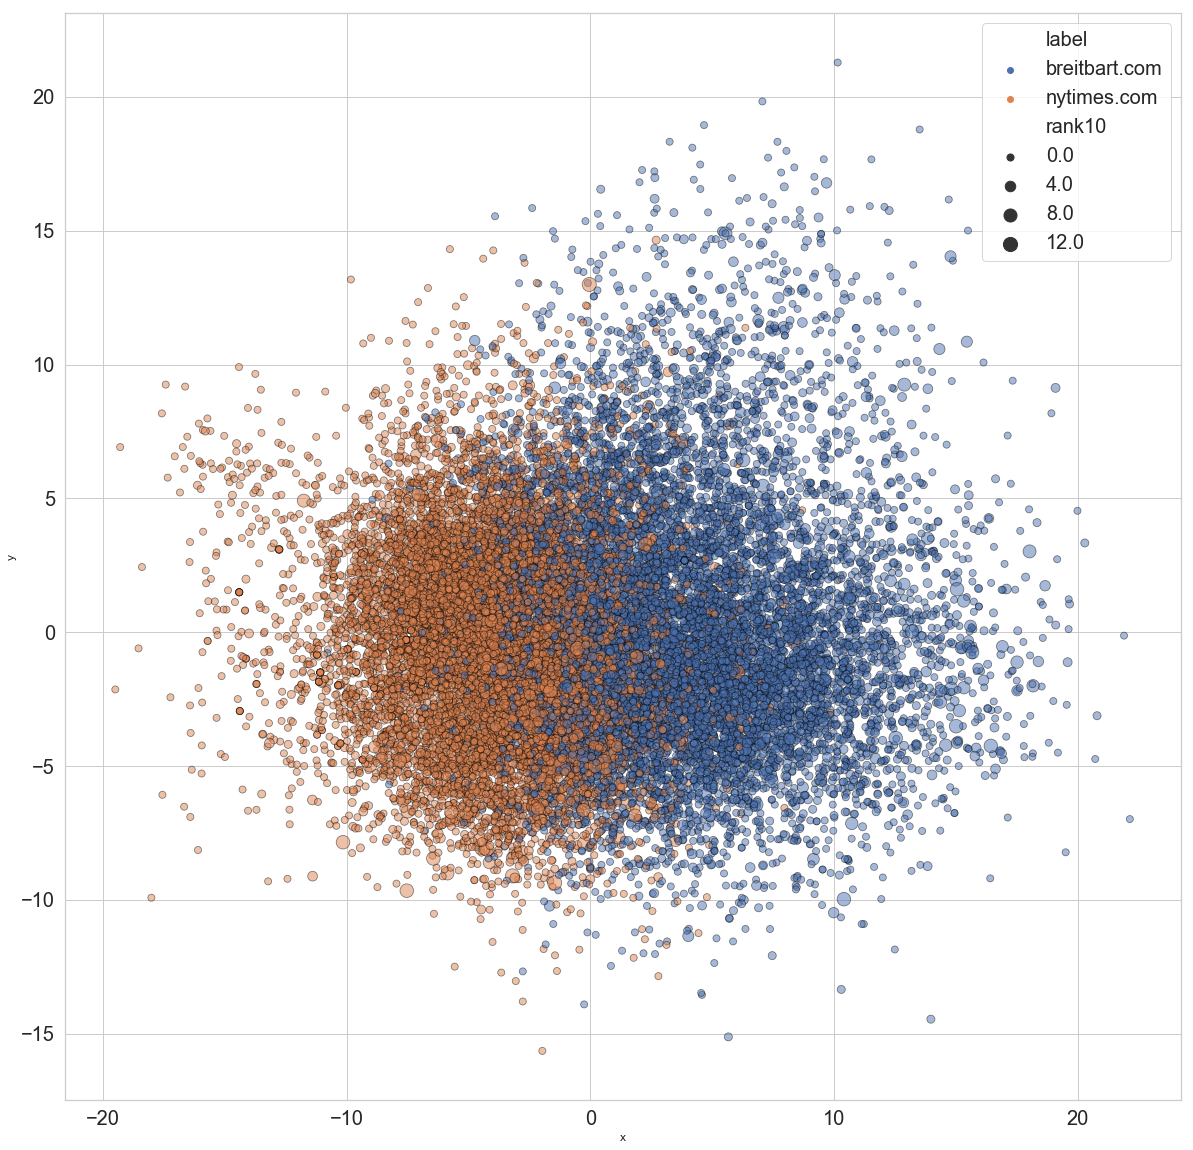

In [85]:
points = dfp.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

plt.figure(figsize=(20,20))

ax = sns.scatterplot(
    x='x', y='y',
    data=points.sample(frac=1),
    hue='label',
    edgecolor='black',
    size='rank10',
    sizes=(50, 200),
    alpha=0.5,
)

plt.rcParams.update({
    'axes.titlesize': 30,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

plt.legend()

In [90]:
rows = []
for d1 in tqdm(df.label.unique()):
    
    ddf = df[(df.label==d1)&(df['count'] > 10)]
    
    for d2 in df.label.unique():
        
        ps = ddf[f'p_{d2}']
        
        counts = np.log10(ddf['count'])
        c_real, _ = stats.pearsonr(ps, counts)
        
        c_rand = []
        for _ in range(100):
            perm = perm = np.random.permutation(len(counts))
            c_rand.append(stats.pearsonr(ps, counts.iloc[perm])[0])

        z = (c_real - np.mean(c_rand)) / np.std(c_rand)
        rows.append((d1, d2, z))

100%|██████████| 42/42 [00:58<00:00,  1.32s/it]


In [91]:
zdf = pd.DataFrame(rows, columns=('d1', 'd2', 'z'))

In [92]:
zdf.sort_values('z', ascending=False)

,d1,d2,z
108,nbcnews.com,thehill.com,13.775258
104,nbcnews.com,washingtonexaminer.com,13.623195
1322,foxnews.com,washingtonexaminer.com,11.267220
216,huffingtonpost.com,dailykos.com,11.216345
1368,nytimes.com,thehill.com,10.971041
1358,nytimes.com,rawstory.com,10.532360
1318,foxnews.com,breitbart.com,9.889623
1336,foxnews.com,dailycaller.com,9.639763
1346,nytimes.com,nbcnews.com,9.564460
98,nbcnews.com,rawstory.com,9.473522


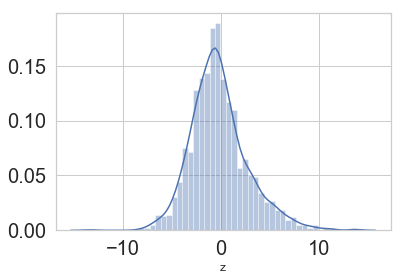

In [93]:
sns.distplot(zdf.z)